In [1]:
import numpy as np
import matplotlib.pyplot as pl
from sklearn.utils import class_weight
import tensorflow as tf
import numpy as np
from tensorflow.keras import Sequential, activations, Input
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import (
    BatchNormalization, Activation, SpatialDropout2D, GlobalAveragePooling2D,
    Dense, Dropout, Flatten,
    Conv2D, MaxPooling2D, SeparableConv2D
)
from tensorflow.keras.layers.experimental.preprocessing import Rescaling

# Import project utils scripts
import os
import sys

src_path = os.path.join('../src/')

if src_path not in sys.path:
    sys.path.append(src_path)

from statisticsUtils import recall_precision_fscore_from_confusion_matrix
from labelsUtils import Label
from regionUtils import vietnam_labels_coordinates
from rasterUtils import make_dataset_from_raster_files
from bandUtils import Band
from visualizationUtils import plot_confusion_matrix
from convNetUtils import (
    cross_validation,
    evaluate_model,
    compute_class_weights,
    images_from_dataset,
    labels_from_dataset,
    train_model,
    AUGMENTATIONS,
    ImageSequence,
)

/home/simon/miniconda3/envs/tb/lib/python3.9/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  warnings.warn(


In [2]:
EPOCHS = 500
DATA_ROOT_PATH ='../data/'
LABELS_COORDINATES = vietnam_labels_coordinates()

In [3]:
labels = [
    Label.COFFEE,
    # Label.NATIVEVEGE, now replaced by DENSE_FOREST
    Label.DENSE_FOREST,
    Label.URBAN,
    Label.WATER,
    Label.PEPPER,
    Label.TEA,
]

In [4]:
NB_PIXEL_AROUND=4

In [5]:
dataset_args = dict(
    labels = labels,
    raster_paths = [DATA_ROOT_PATH + 'Vietnam_2018_january_to_april/merged.tif'],
    labels_coordinates_list = [LABELS_COORDINATES],
    nb_pixel_around = NB_PIXEL_AROUND
)

dataset_2018 = make_dataset_from_raster_files(**dataset_args)
np.random.shuffle(dataset_2018)

In [6]:
dataset_args = dict(
    labels = labels,
    raster_paths = [DATA_ROOT_PATH + 'Vietnam_2019_january_to_april/merged.tif'],
    labels_coordinates_list = [LABELS_COORDINATES],
    nb_pixel_around = NB_PIXEL_AROUND
)

dataset_2019 = make_dataset_from_raster_files(**dataset_args)
np.random.shuffle(dataset_2019)

In [7]:
labels_names = [label.name for label in labels]
nb_labels = len(labels_names)

bands = [
    Band.COASTAL_AEROSOL.value, 
    Band.BLUE.value, 
    Band.GREEN.value, 
    Band.RED.value, 
    Band.NIR.value, 
    Band.SWIR1.value, 
    Band.SWIR2.value, 
]

model_name = "january_to_april_2018"

# images have all the same shapes, take the shape of the first image
image_width = 9
image_height = 9
image_depth = len(bands)
nb_outputs = len(labels)

# Create model
model = Sequential([
    Rescaling(1./2**16, input_shape=(image_width, image_height, image_depth)),
    BatchNormalization(),
    Conv2D(filters=32, kernel_size=(3, 3), padding="same", activation="relu"),
    Conv2D(filters=32, kernel_size=(3, 3), padding="same", activation="relu"),
    MaxPooling2D(pool_size=(3, 3)),
    Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation="relu"),
    Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation="relu"),
    MaxPooling2D(pool_size=(3, 3)),
    SpatialDropout2D(0.25),
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.25),
    Dense(nb_outputs, activation='softmax'),
])

model.summary()

# Specify optimizer and loss function
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 9, 9, 7)           0         
_________________________________________________________________
batch_normalization (BatchNo (None, 9, 9, 7)           28        
_________________________________________________________________
conv2d (Conv2D)              (None, 9, 9, 32)          2048      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 9, 9, 32)          9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 3, 3, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 64)          18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 3, 64)          3

In [8]:
# Create train sets
X_train = images_from_dataset(dataset_2018, bands)
y_train = labels_from_dataset(dataset_2018, labels_names)
Y_train = to_categorical(y_train, num_classes=len(labels_names))

# Create test sets
X_test = images_from_dataset(dataset_2019, bands)
y_test = labels_from_dataset(dataset_2019, labels_names)
Y_test = to_categorical(y_test, num_classes=len(labels_names))

In [9]:
# create data generators
train_datagen = ImageSequence(X_train, Y_train, batch_size=32, augmentations=AUGMENTATIONS)

class_weights = compute_class_weights(y_train)

history, trained_model = train_model(
    model=model,
    train_datagen=train_datagen,
    validation_datagen=None,
    class_weights=class_weights,
    epochs=EPOCHS,
    steps_per_epoch=len(y_train) / 32,
    early_stopping=False,
    model_checkpoint_cb=False,
)

Epoch 1/500
290/290 [==============================] - 1s 3ms/step - loss: 1.0898 - accuracy: 0.5872
Epoch 2/500
290/290 [==============================] - 1s 3ms/step - loss: 0.9005 - accuracy: 0.6677
Epoch 3/500
290/290 [==============================] - 1s 3ms/step - loss: 0.8153 - accuracy: 0.7013
Epoch 4/500
290/290 [==============================] - 1s 3ms/step - loss: 0.7631 - accuracy: 0.7232
Epoch 5/500
290/290 [==============================] - 1s 3ms/step - loss: 0.7150 - accuracy: 0.7419
Epoch 6/500
290/290 [==============================] - 1s 4ms/step - loss: 0.6813 - accuracy: 0.7532
Epoch 7/500
290/290 [==============================] - 1s 4ms/step - loss: 0.6383 - accuracy: 0.7727
Epoch 8/500
290/290 [==============================] - 1s 4ms/step - loss: 0.6198 - accuracy: 0.7746
Epoch 9/500
290/290 [==============================] - 1s 4ms/step - loss: 0.5955 - accuracy: 0.7858
Epoch 10/500
290/290 [==============================] - 1s 4ms/step - loss: 0.5816 - accura

290/290 [==============================] - 1s 5ms/step - loss: 0.2291 - accuracy: 0.9161
Epoch 161/500
290/290 [==============================] - 1s 4ms/step - loss: 0.2274 - accuracy: 0.9159
Epoch 162/500
290/290 [==============================] - 1s 4ms/step - loss: 0.2431 - accuracy: 0.9111
Epoch 163/500
290/290 [==============================] - 1s 4ms/step - loss: 0.2458 - accuracy: 0.9131
Epoch 164/500
290/290 [==============================] - 1s 5ms/step - loss: 0.2350 - accuracy: 0.9118
Epoch 165/500
290/290 [==============================] - 1s 4ms/step - loss: 0.2204 - accuracy: 0.9203
Epoch 166/500
290/290 [==============================] - 1s 4ms/step - loss: 0.2257 - accuracy: 0.9132
Epoch 167/500
290/290 [==============================] - 1s 5ms/step - loss: 0.2442 - accuracy: 0.9104
Epoch 168/500
290/290 [==============================] - 1s 5ms/step - loss: 0.2335 - accuracy: 0.9117
Epoch 169/500
290/290 [==============================] - 1s 5ms/step - loss: 0.2296 - a

290/290 [==============================] - 1s 5ms/step - loss: 0.1839 - accuracy: 0.9350
Epoch 319/500
290/290 [==============================] - 1s 4ms/step - loss: 0.1851 - accuracy: 0.9323
Epoch 320/500
290/290 [==============================] - 1s 5ms/step - loss: 0.2026 - accuracy: 0.9281
Epoch 321/500
290/290 [==============================] - 1s 5ms/step - loss: 0.1963 - accuracy: 0.9263
Epoch 322/500
290/290 [==============================] - 2s 5ms/step - loss: 0.1954 - accuracy: 0.9286
Epoch 323/500
290/290 [==============================] - 1s 4ms/step - loss: 0.1896 - accuracy: 0.9291
Epoch 324/500
290/290 [==============================] - 1s 4ms/step - loss: 0.1955 - accuracy: 0.9311
Epoch 325/500
290/290 [==============================] - 1s 5ms/step - loss: 0.1874 - accuracy: 0.9316
Epoch 326/500
290/290 [==============================] - 2s 6ms/step - loss: 0.1933 - accuracy: 0.9304
Epoch 327/500
290/290 [==============================] - 2s 6ms/step - loss: 0.2137 - a

290/290 [==============================] - 2s 6ms/step - loss: 0.1620 - accuracy: 0.9382
Epoch 477/500
290/290 [==============================] - 1s 5ms/step - loss: 0.1798 - accuracy: 0.9360
Epoch 478/500
290/290 [==============================] - 1s 5ms/step - loss: 0.1631 - accuracy: 0.9419
Epoch 479/500
290/290 [==============================] - 1s 5ms/step - loss: 0.1740 - accuracy: 0.9380
Epoch 480/500
290/290 [==============================] - 1s 5ms/step - loss: 0.1692 - accuracy: 0.9395
Epoch 481/500
290/290 [==============================] - 1s 5ms/step - loss: 0.1870 - accuracy: 0.9351
Epoch 482/500
290/290 [==============================] - 1s 5ms/step - loss: 0.1757 - accuracy: 0.9363
Epoch 483/500
290/290 [==============================] - 1s 5ms/step - loss: 0.1766 - accuracy: 0.9345
Epoch 484/500
290/290 [==============================] - 1s 4ms/step - loss: 0.1586 - accuracy: 0.9439
Epoch 485/500
290/290 [==============================] - 1s 5ms/step - loss: 0.1670 - a

In [10]:
conf_matrix, accuracy, loss = evaluate_model(trained_model, X_test, Y_test, y_test, len(labels_names))

In [11]:
print("loss: ", loss)
print("accuracy: ", accuracy)

loss:  0.6761635541915894
accuracy:  0.8365612030029297


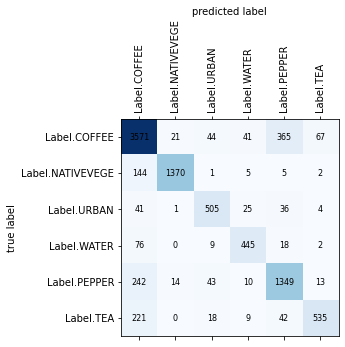

In [12]:
plot_confusion_matrix(conf_matrix, labels)

In [13]:
recall, precision, fscore = recall_precision_fscore_from_confusion_matrix(conf_matrix)

print("Precisions: ", precision)
print("Mean precision: ", np.mean(precision))
print("\nRecalls: ", recall)
print("Mean recall: ", np.mean(recall))
print("\nF-Score: ", fscore)
print("Mean f-score: ", np.mean(fscore))

Precisions:  [0.8314319  0.97439545 0.81451613 0.8317757  0.74325069 0.85874799]
Mean precision:  0.8423529763144136

Recalls:  [0.8690679  0.89718402 0.8251634  0.80909091 0.80730102 0.64848485]
Mean recall:  0.8093820157186439

F-Score:  [0.84983341 0.93419707 0.81980519 0.8202765  0.77395295 0.73895028]
Mean f-score:  0.8228359006548741
